# Onderzoekvraag

Hoe beïnvloeden regen en koude temperaturen het aantal gehuurde taxi’s in deze dataset?

### Librarys importeren

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Databases

Hier onder vind je de taxi data base.

In [129]:
df = pd.read_csv("taxi_dataset.csv")
df.head()

,id,name,price,surge_multiplier,timestamp,datetime,timezone,source,destination,latitude,longitude,distance
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,UberXL,12.0,1.0,1.543616e+09,2018-11-30 22:13:01,America/New_York,North End,West End,42.3647,-71.0542,1.11
1,23f145da-f0c1-4d1f-a184-496bc003a7db,Black,16.0,1.0,1.544698e+09,2018-12-13 10:50:11,America/New_York,North End,West End,42.3647,-71.0542,1.11
2,357559cb-8c58-4278-a41a-e33b2e0997a3,UberX,7.5,1.0,1.544729e+09,2018-12-13 19:15:03,America/New_York,North End,West End,42.3647,-71.0542,1.11
3,50ef1165-9d23-416c-a65c-18906207b295,WAV,7.5,1.0,1.545005e+09,2018-12-16 23:55:11,America/New_York,North End,West End,42.3647,-71.0542,1.11
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,Black SUV,26.0,1.0,1.544748e+09,2018-12-14 00:40:07,America/New_York,North End,West End,42.3647,-71.0542,1.11


Dit is een weerdatabase van Boston. Deze heb ik gebruikt om te analyseren op welke dagen het regent, zodat ik kan zien hoeveel taxi ritten er zijn op regenachtige dagen. Onder het voorbeeld van de database zie je wat de afkortingen zijn.

In [130]:
dw = pd.read_csv("boston_weather_data.csv")
dw.head()

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5


### Uitleg voor deze tabel

Kolommen in de Weerdata:
1. time: De datum waarop de metingen zijn gedaan.
2. tavg: De gemiddelde temperatuur op die datum (in graden Celsius).
3. tmin: De minimum temperatuur op die datum (in graden Celsius).
4. tmax: De maximum temperatuur op die datum (in graden Celsius).
5. prcp: De hoeveelheid neerslag op die datum (in millimeters). Een waarde van 0 betekent geen neerslag.
6. wdir: De richting van de wind (in graden).
7. wspd: De snelheid van de wind (in km/u).
8. pres: De luchtdruk (in hPa).

## Data analysis

We hebben onderzocht hoeveel dagen er in de taxi-database voorkomen en hoeveel daarvan dagen met regen zijn. De taxi-database bevat gegevens van Boston, dus deze analyse is specifiek gericht op die regio. Daarnaast hebben we ook het aantal ritten per dag in kaart gebracht, zodat we kunnen zien op welke dagen meer of minder taxi's zijn gebruikt.

In [131]:
# Laad de datasets vanuit CSV-bestanden
taxi_data = pd.read_csv('taxi_dataset.csv') 
weather_data = pd.read_csv('boston_weather_data.csv')

# Zorg ervoor dat de datum in de juiste indeling staat in taxi_data
taxi_data['date'] = pd.to_datetime(taxi_data['datetime']).dt.date

# Zorg ervoor dat de datum in de juiste indeling staat in weather_data
weather_data['time'] = pd.to_datetime(weather_data['time']).dt.date

# Controleer het aantal unieke dagen in de taxi data
unique_taxi_days = taxi_data['date'].nunique()
print(f"Aantal unieke dagen in taxi data: {unique_taxi_days}")

# Controleer het aantal dagen met neerslag in de weersdata
rainy_days = weather_data[weather_data['prcp'] > 0]['time']
unique_rainy_days = rainy_days.nunique()
print(f"Aantal unieke dagen met neerslag in de weersdata: {unique_rainy_days}")

# Tel het aantal dagen dat in zowel taxi_data als rainy_days voorkomt
common_rainy_days = rainy_days[rainy_days.isin(taxi_data['date'])]
number_of_rainy_days_with_taxi_data = len(common_rainy_days)

print(f"Aantal dagen met regen die ook in de taxi database staan: {number_of_rainy_days_with_taxi_data}")

# Optioneel: Lijst de specifieke dagen met regen en taxi data, en het aantal ritten op die dagen
print("Dagen met regen en taxi data:")

# Maak een DataFrame voor de dagen met regen die ook in de taxi data staan
rainy_days_with_rides = pd.DataFrame({
    'date': common_rainy_days,
    'ride_count': [taxi_data[taxi_data['date'] == date].shape[0] for date in common_rainy_days]
})

print(rainy_days_with_rides)

Aantal unieke dagen in taxi data: 17
Aantal unieke dagen met neerslag in de weersdata: 1310
Aantal dagen met regen die ook in de taxi database staan: 6
Dagen met regen en taxi data:
            date  ride_count
2096  2018-11-26       17587
2097  2018-11-27       42366
2102  2018-12-02       25083
2116  2018-12-16       24889
2117  2018-12-17       25243
2118  2018-12-18       20234


We hebben gekeken naar dagen met veel of weinig taxi-ritten, zoals 4, 9 en 10 december 2018, waarop het aantal ritten laag was. Het weer op die dagen verschilde niet veel van de andere dagen. Het was lastig om de oorzaken te vinden, zoals evenementen, omdat deze data al zes jaar oud zijn. Ook op dagen met meer ritten, zoals 27 en 28 november 2018, konden we geen duidelijke reden vinden voor de verschillen in het aantal ritten.

In [132]:
# Zorg ervoor dat de 'datetime' kolom in de juiste datetime indeling staat
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])

# Extraheer alleen het jaar, de maand en de dag
taxi_data['date'] = taxi_data['datetime'].dt.date

# Tel het aantal ritten per datum
daily_ride_counts = taxi_data.groupby('date').size().reset_index(name='ride_count')

# Bekijk het aantal unieke dagen in de taxi data
unique_days = daily_ride_counts['date'].nunique()
print(f"Aantal unieke dagen in de taxi data: {unique_days}")

# Optioneel: Bekijk de unieke dagen met ritten
print("Unieke dagen met ritten en hun aantal:")
print(daily_ride_counts)

Aantal unieke dagen in de taxi data: 17
Unieke dagen met ritten en hun aantal:
          date  ride_count
0   2018-11-26       17587
1   2018-11-27       42366
2   2018-11-28       40900
3   2018-11-29       33508
4   2018-11-30       25171
5   2018-12-01       24951
6   2018-12-02       25083
7   2018-12-03       24907
8   2018-12-04        6932
9   2018-12-09        1006
10  2018-12-10        1561
11  2018-12-13       21526
12  2018-12-14       24777
13  2018-12-15       25022
14  2018-12-16       24889
15  2018-12-17       25243
16  2018-12-18       20234


In [133]:
daily_ride_counts['is_rainy'] = daily_ride_counts['date'].isin(weather_data[weather_data['prcp'] > 0]['time'])

# Gemiddeld aantal ritten per dag op regenachtige en niet-regenachtige dagen berekenen
average_rides = daily_ride_counts.groupby('is_rainy')['ride_count'].mean().reset_index()

# Geef de kolommen begrijpelijke namen
average_rides['is_rainy'] = average_rides['is_rainy'].map({True: 'Regenachtig', False: 'Niet Regenachtig'})

# Print de resultaten
print(average_rides)

           is_rainy    ride_count
0  Niet Regenachtig  20932.818182
1       Regenachtig  25900.333333


## Grafieken

In deze grafiek zien we de verdeling van het aantal taxi-ritten per dag, vergezeld van een Kernel Density Estimation (KDE) voor extra duidelijkheid. Het histogram toont de frequentie van het aantal ritten op de y-as in vergelijking met het aantal ritten per dag op de x-as. De rode, gestippelde lijn markeert het gemiddelde aantal ritten per dag.

Hieruit blijkt dat er enkele uitschieters zijn: op sommige dagen waren er veel meer of minder ritten dan op andere dagen. Deze variaties worden duidelijker weergegeven in de tweede tabel hieronder. Uitleg hier van kunt u boven vinden in de analyse.

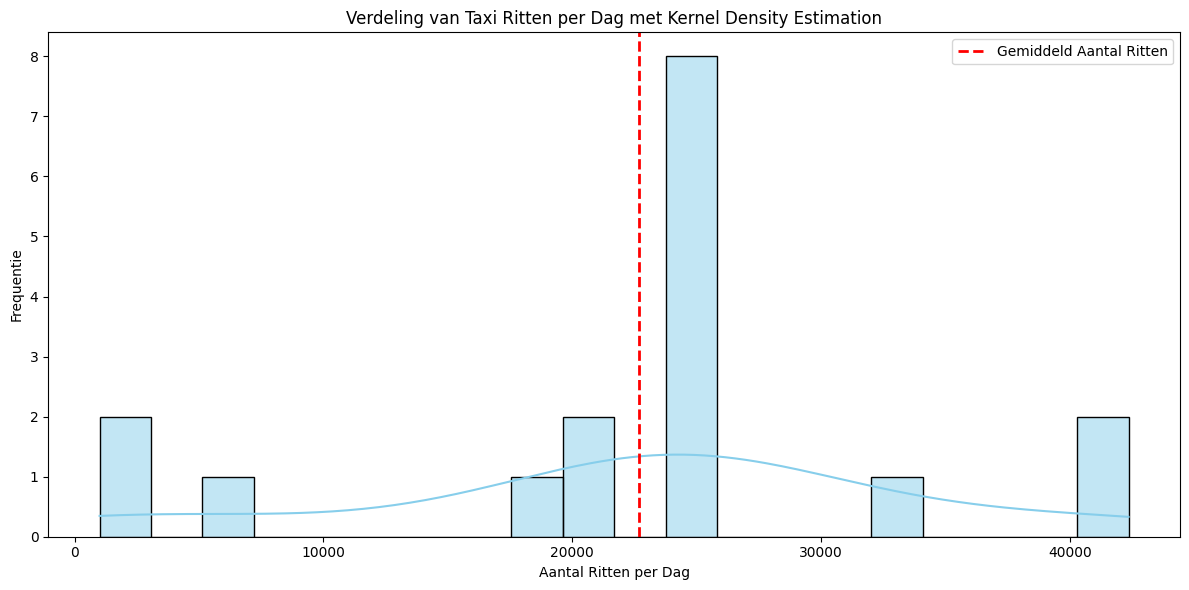

In [134]:
# Grafiek maken
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_ride_counts, x='ride_count', bins=20, kde=True, color='skyblue')
plt.axvline(daily_ride_counts['ride_count'].mean(), color='red', linestyle='dashed', linewidth=2, label='Gemiddeld Aantal Ritten')
plt.title('Verdeling van Taxi Ritten per Dag met Kernel Density Estimation')
plt.xlabel('Aantal Ritten per Dag')
plt.ylabel('Frequentie')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

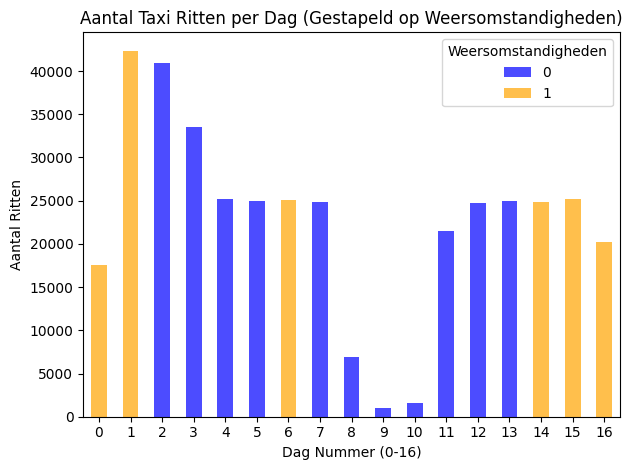

In [135]:
# Voeg een kolom toe die aangeeft of de dag regenachtig is (1) of niet (0).
daily_ride_counts['is_rainy'] = daily_ride_counts['date'].isin(weather_data[weather_data['prcp'] > 0]['time'])

# Zet de waarden in de 'is_rainy' kolom om naar integers (0 of 1).
daily_ride_counts['is_rainy'] = daily_ride_counts['is_rainy'].astype(int)

# Voeg een nieuwe kolom toe die een unieke dagnummering aanmaakt.
daily_ride_counts['day_number'] = range(len(daily_ride_counts))

# Maak een draaitabel met het aantal ritten per dag, gesplitst op regenachtige en niet-regenachtige dagen.
pivot_table = daily_ride_counts.pivot(index='day_number', columns='is_rainy', values='ride_count').fillna(0)

# Plot een gestapelde staafdiagram van het aantal taxi-ritten per dag op basis van weersomstandigheden.
plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, color=['blue', 'orange'], alpha=0.7)
plt.title('Aantal Taxi Ritten per Dag (Gestapeld op Weersomstandigheden)')
plt.xlabel('Dag Nummer (0-16)')
plt.ylabel('Aantal Ritten')
plt.xticks(rotation=0)
plt.legend(title='Weersomstandigheden')
plt.tight_layout()
plt.show()

In deze grafiek zien we het aantal ritten op regenachtige en niet-regenachtige dagen. De huidige vergelijking is echter niet volledig representatief, omdat het slechts op 6 van de 17 dagen heeft geregend. Hierdoor is de vergelijking tussen de twee situaties niet helemaal eerlijk. Om een betere vergelijking te maken, hebben we hieronder een tweede grafiek toegevoegd waarin het gemiddelde aantal ritten per dag voor regenachtige en niet-regenachtige dagen wordt weergegeven.

<Figure size 1200x600 with 0 Axes>

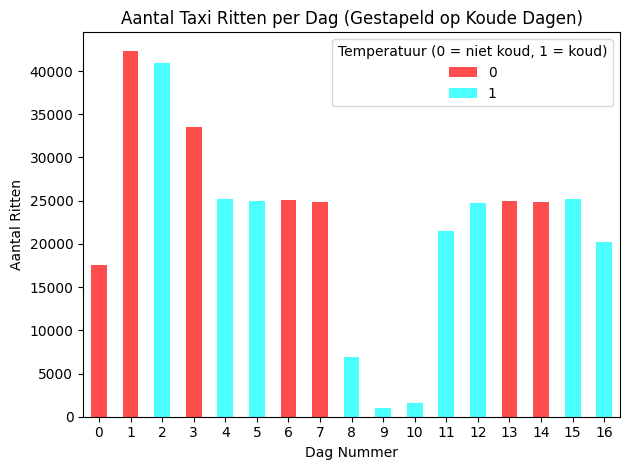

In [139]:
# Definieer een drempel voor koude dagen, bijvoorbeeld 5°C
cold_threshold =  5 

# Voeg een kolom toe die aangeeft of een dag koud is (1) of niet (0)
daily_ride_counts['is_cold'] = daily_ride_counts['date'].isin(weather_data[weather_data['tavg'] < cold_threshold]['time'])

# Zet de waarden in de 'is_cold' kolom om naar integers (0 of 1)
daily_ride_counts['is_cold'] = daily_ride_counts['is_cold'].astype(int)

# Maak een draaitabel met het aantal ritten per dag, gesplitst op koude en niet-koude dagen
pivot_table_cold = daily_ride_counts.pivot(index='day_number', columns='is_cold', values='ride_count').fillna(0)

# Plot een gestapelde staafdiagram van het aantal taxi-ritten per dag op basis van temperatuur
plt.figure(figsize=(12, 6))
pivot_table_cold.plot(kind='bar', stacked=True, color=['red', 'cyan'], alpha=0.7)
plt.title('Aantal Taxi Ritten per Dag (Gestapeld op Koude Dagen)')
plt.xlabel('Dag Nummer')
plt.ylabel('Aantal Ritten')
plt.xticks(rotation=0)
plt.legend(title='Temperatuur (0 = niet koud, 1 = koud)')
plt.tight_layout()
plt.show()


In deze grafiek wordt het aantal ritten op koude en niet-koude dagen weergegeven (koude dagen zien we als dagen waarbij het gemidelde tempertuur van die dag onder de 5 graden zit). De huidige vergelijking is echter mogelijk niet volledig representatief, aangezien er meer koude dagen zijn dan warme dagen. Om een duidelijker verschil te kunnen zien, zou het nuttig zijn om bijvoorbeeld data van andere maanden te analyseren. Dit zou echter vereisen dat we meer gedetailleerde informatie van de taxibedrijven beschikbaar hebben.

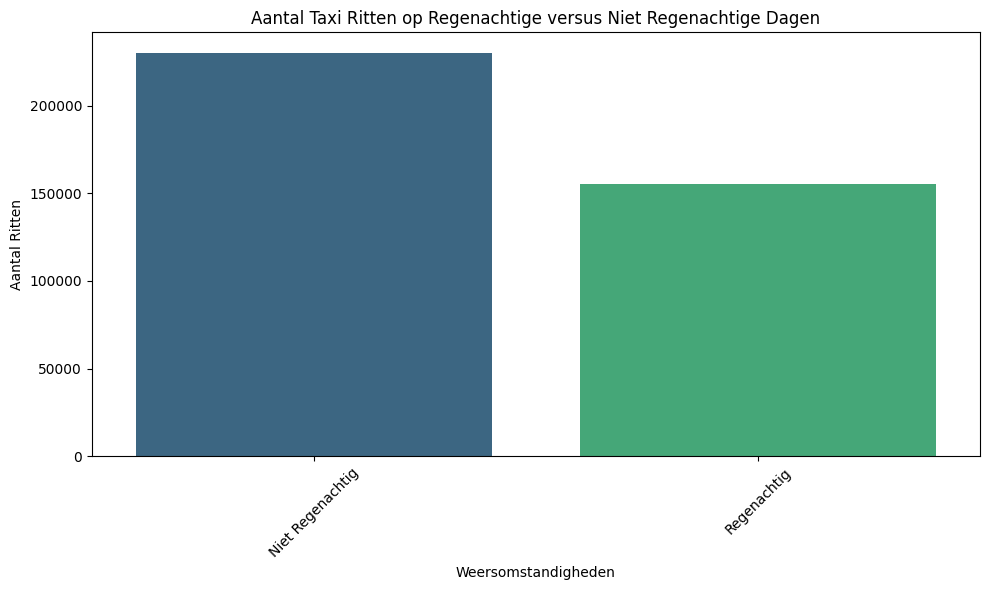

In [63]:
# Zorg ervoor dat de datum in de juiste indeling staat in taxi_data
taxi_data['date'] = pd.to_datetime(taxi_data['datetime']).dt.date

# Zorg ervoor dat de datum in de juiste indeling staat in weather_data
weather_data['time'] = pd.to_datetime(weather_data['time']).dt.date

# Tel het aantal ritten per datum
daily_ride_counts = taxi_data.groupby('date').size().reset_index(name='ride_count')

# Voeg de weerdata toe
daily_ride_counts['is_rainy'] = daily_ride_counts['date'].isin(weather_data[weather_data['prcp'] > 0]['time'])

# Groepeer op regenachtige en niet-regenachtige dagen en tel de ritten
summary = daily_ride_counts.groupby('is_rainy')['ride_count'].sum().reset_index()

# Geef de kolommen een begrijpelijke naam
summary['is_rainy'] = summary['is_rainy'].map({True: 'Regenachtig', False: 'Niet Regenachtig'})

# Maak de grafiek
plt.figure(figsize=(10, 6))
sns.barplot(x='is_rainy', y='ride_count', data=summary, hue='is_rainy', palette='viridis', legend=False)
plt.title('Aantal Taxi Ritten op Regenachtige versus Niet Regenachtige Dagen')
plt.xlabel('Weersomstandigheden')
plt.ylabel('Aantal Ritten')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Index(['is_rainy', 'ride_count'], dtype='object')


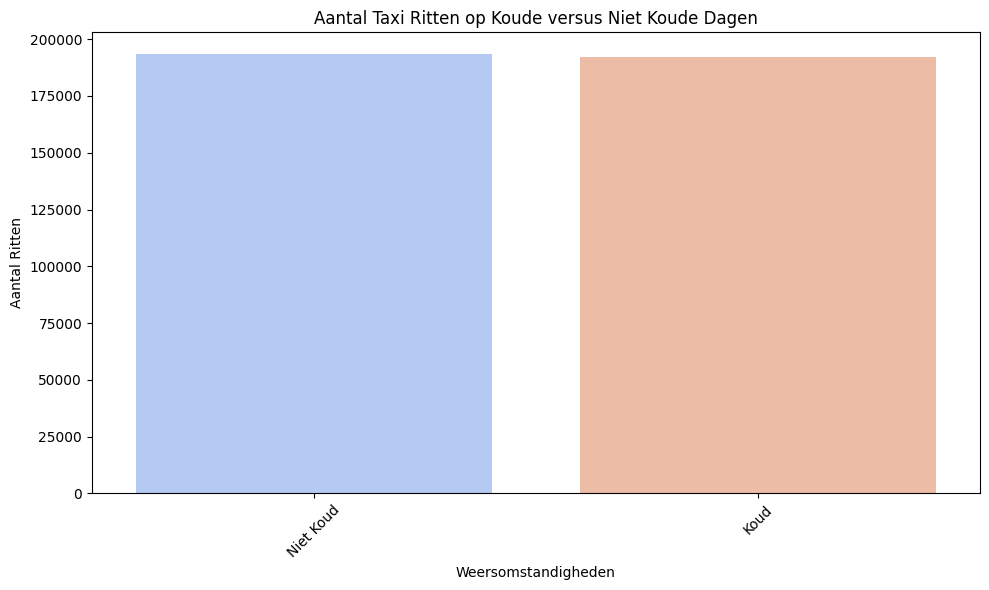

In [125]:
# Definieer een drempel voor koude dagen (bijv. onder 5°C)
cold_threshold = 5  

# Zorg ervoor dat de datum in de juiste indeling staat in taxi_data
taxi_data['date'] = pd.to_datetime(taxi_data['datetime']).dt.date

# Zorg ervoor dat de datum in de juiste indeling staat in weather_data
weather_data['time'] = pd.to_datetime(weather_data['time']).dt.date

# Tel het aantal ritten per datum
daily_ride_counts = taxi_data.groupby('date').size().reset_index(name='ride_count')

# Voeg een kolom toe die aangeeft of de dag koud is
daily_ride_counts['is_cold'] = daily_ride_counts['date'].isin(weather_data[weather_data['tavg'] < cold_threshold]['time'])

# Groepeer op koude en niet-koude dagen en tel de ritten
summary_cold = daily_ride_counts.groupby('is_cold')['ride_count'].sum().reset_index()

# Geef de kolommen een begrijpelijke naam
summary_cold['is_cold'] = summary_cold['is_cold'].map({True: 'Koud', False: 'Niet Koud'})

# Maak de grafiek
plt.figure(figsize=(10, 6))
sns.barplot(x='is_cold', y='ride_count', data=summary_cold, hue='is_cold', palette='coolwarm', legend=False)
plt.title('Aantal Taxi Ritten op Koude versus Niet Koude Dagen')
plt.xlabel('Weersomstandigheden')
plt.ylabel('Aantal Ritten')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


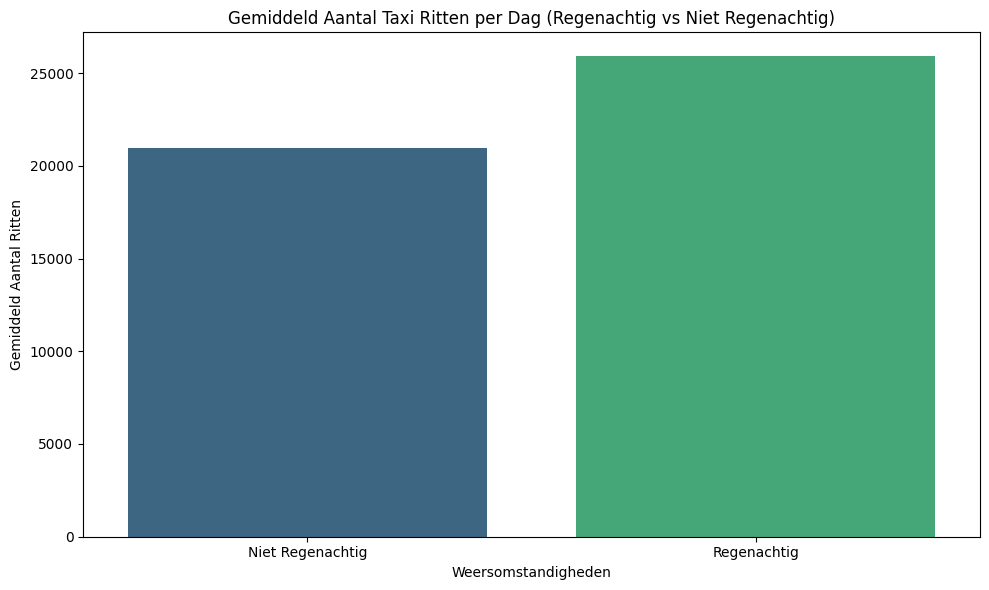

In [122]:
# Grafiek maken
plt.figure(figsize=(10, 6))
sns.barplot(x='is_rainy', y='ride_count', data=average_rides, hue='is_rainy', palette='viridis', legend=False)
plt.title('Gemiddeld Aantal Taxi Ritten per Dag (Regenachtig vs Niet Regenachtig)')
plt.xlabel('Weersomstandigheden')
plt.ylabel('Gemiddeld Aantal Ritten')
plt.tight_layout()
plt.show()

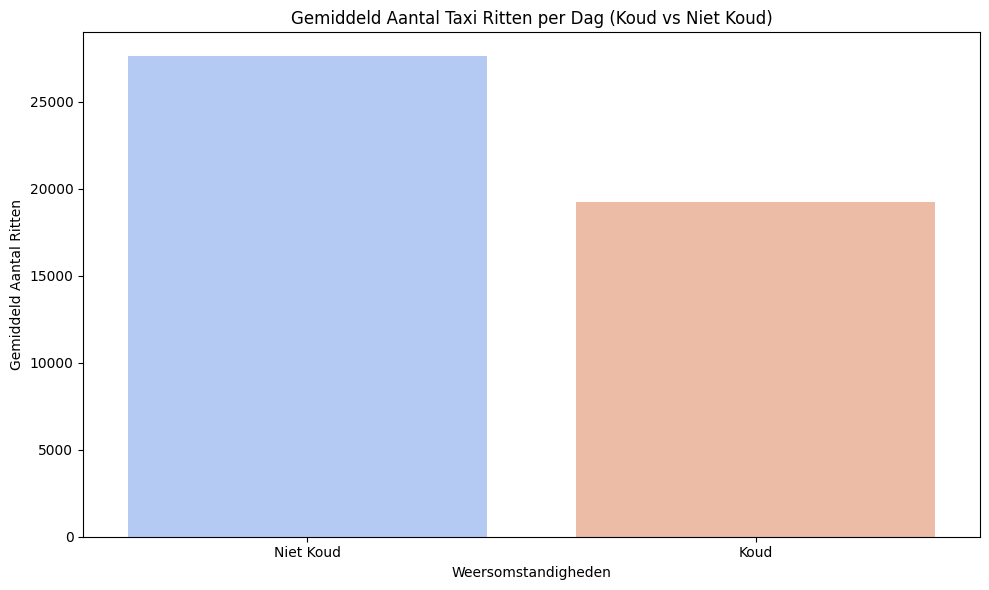

In [126]:
# Zorg ervoor dat we het gemiddelde aantal ritten per dag berekenen voor koude en niet-koude dagen
average_rides_cold = daily_ride_counts.groupby('is_cold')['ride_count'].mean().reset_index()

# Geef de kolommen een begrijpelijke naam
average_rides_cold['is_cold'] = average_rides_cold['is_cold'].map({True: 'Koud', False: 'Niet Koud'})

# Grafiek maken voor koud vs niet-koud
plt.figure(figsize=(10, 6))
sns.barplot(x='is_cold', y='ride_count', data=average_rides_cold, hue='is_cold', palette='coolwarm', legend=False)
plt.title('Gemiddeld Aantal Taxi Ritten per Dag (Koud vs Niet Koud)')
plt.xlabel('Weersomstandigheden')
plt.ylabel('Gemiddeld Aantal Ritten')
plt.tight_layout()
plt.show()


### Model creëren

In [49]:
# Scheid de kenmerken (X) en de target (y)
X = daily_ride_counts[['is_rainy']]
y = daily_ride_counts['ride_count']

In [50]:
# Split de data in trainings- en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Maak een Lineaire Regressie model aan
model = LinearRegression()

# Train het model
model.fit(X_train, y_train)


LinearRegression()

Mean Squared Error: 104093300.50
R² Score: -0.26


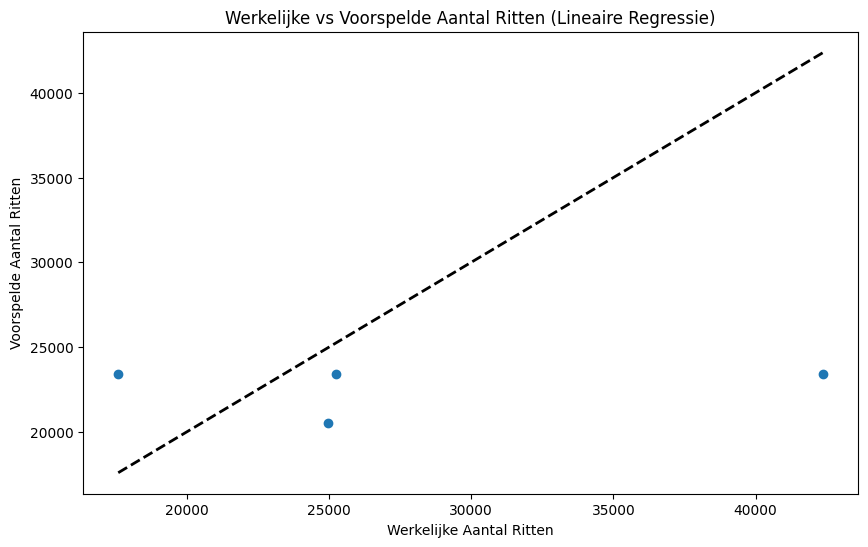

In [51]:
# Maak voorspellingen
y_pred = model.predict(X_test)

# Bereken Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Bereken R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

# Plot van Werkelijke vs Voorspelde Aantal Ritten
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Werkelijke Aantal Ritten')
plt.ylabel('Voorspelde Aantal Ritten')
plt.title('Werkelijke vs Voorspelde Aantal Ritten (Lineaire Regressie)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

### Conclusie 

Het is lastig om definitieve conclusies te trekken over het effect van weersomstandigheden op het aantal taxi-ritten. Hoewel de gemiddelde analyse aangeeft dat er op regenachtige dagen meer ritten plaatsvinden, betekent dit niet noodzakelijkerwijs dat er een direct verband is. Aangezien deze database niet is gebaseerd op echte gegevens, kunnen de hogere aantallen op regenachtige dagen ook simpelweg het gevolg zijn van toeval. Verdere studies met uitgebreide en nauwkeurige gegevens zijn nodig om een beter inzicht te krijgen in de relatie tussen het weer en het taxi-rit gedrag in Boston.

In [67]:
X = daily_ride_counts[['is_cold']]
y = daily_ride_counts['ride_count']


In [68]:
# Split de data in trainings- en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Maak een Lineaire Regressie model aan
model = LinearRegression()

# Train het model
model.fit(X_train, y_train)

LinearRegression()

Mean Squared Error: 109079064.99
R² Score: -0.32


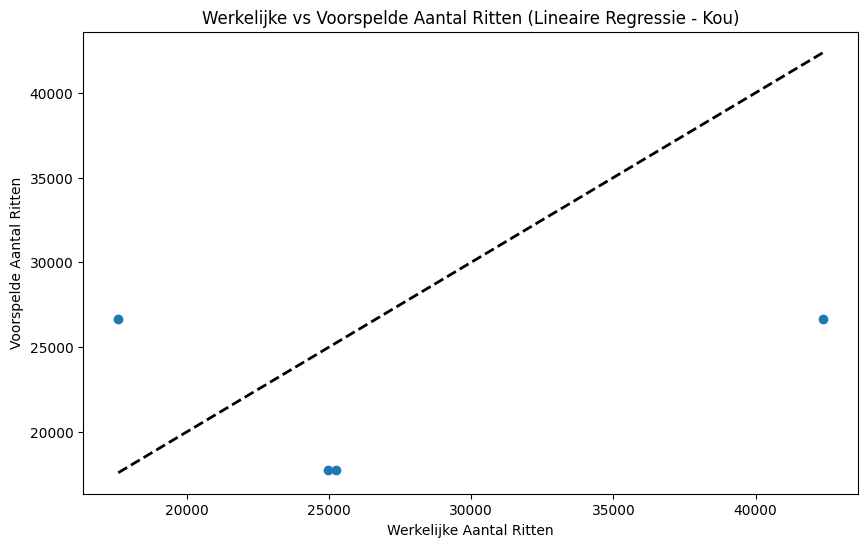

In [69]:
# Maak voorspellingen
y_pred = model.predict(X_test)

# Bereken Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Bereken R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

# Plot van Werkelijke vs Voorspelde Aantal Ritten
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Werkelijke Aantal Ritten')
plt.ylabel('Voorspelde Aantal Ritten')
plt.title('Werkelijke vs Voorspelde Aantal Ritten (Lineaire Regressie - Kou)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

### Conclusie 

Het is lastig om definitieve conclusies te trekken over het effect van weersomstandigheden op het aantal taxi-ritten. Hoewel de gemiddelde analyse aangeeft dat er op niet koude dagen meer ritten plaatsvinden, betekent dit niet noodzakelijkerwijs dat er een direct verband is. Aangezien deze database niet is gebaseerd op echte gegevens, kunnen de hogere aantallen op niet koude dagen ook simpelweg het gevolg zijn van toeval. Verdere studies met uitgebreide en nauwkeurige gegevens zijn nodig om een beter inzicht te krijgen in de relatie tussen het weer en het taxi-rit gedrag in Boston.

## Taxi dataset uitbreiden
We gaan nu onderzoeken of een ander model beter werkt dan een Lineare Regression. En we kijken naar de correlaties tussen de regen en temperatuur vergeleken met de kosten.

### Data-preprocessing

In [70]:
df_cleaned = pd.read_csv("taxi_dataset_cleaned.csv")

In [71]:
dw['time'] = pd.to_datetime(dw['time']).dt.date
df_cleaned['date'] = pd.to_datetime(df_cleaned['datetime']).dt.date

In [72]:
# prcp is de hoeveelheid neerslag in inches, boven 0 betekent dat het regent
dw["rain"] = dw["prcp"] > 0

In [73]:
# merge the data set on the date 
df_merged = pd.merge(df_cleaned, dw, left_on='date', right_on='time', how='inner')
df_merged = df_merged.convert_dtypes()

In [74]:
df_merged.head()

,Unnamed: 0,id,name,price,surge_multiplier,timestamp,datetime,timezone,source,destination,...,date,time,tavg,tmin,tmax,prcp,wdir,wspd,pres,rain
0,0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,4,12.0,1,1543615981.179,2018-11-30 22:13:01,America/New_York,North End,West End,...,2018-11-30,2018-11-30,3.6,0.6,6.7,0.0,302,10.8,1016.3,False
1,1,23f145da-f0c1-4d1f-a184-496bc003a7db,0,16.0,1,1544698211.014,2018-12-13 10:50:11,America/New_York,North End,West End,...,2018-12-13,2018-12-13,-2.6,-6.0,1.7,0.0,39,9.7,1032.8,False
2,2,357559cb-8c58-4278-a41a-e33b2e0997a3,3,7.5,1,1544728503.935,2018-12-13 19:15:03,America/New_York,North End,West End,...,2018-12-13,2018-12-13,-2.6,-6.0,1.7,0.0,39,9.7,1032.8,False
3,3,50ef1165-9d23-416c-a65c-18906207b295,5,7.5,1,1545004511.43,2018-12-16 23:55:11,America/New_York,North End,West End,...,2018-12-16,2018-12-16,6.4,5.0,7.2,13.7,56,28.8,1017.8,True
4,4,91c4861c-1780-42b0-bca1-bbd64a422cc3,1,26.0,1,1544748007.961,2018-12-14 00:40:07,America/New_York,North End,West End,...,2018-12-14,2018-12-14,2.5,-1.6,7.8,0.0,174,9.4,1031.1,False


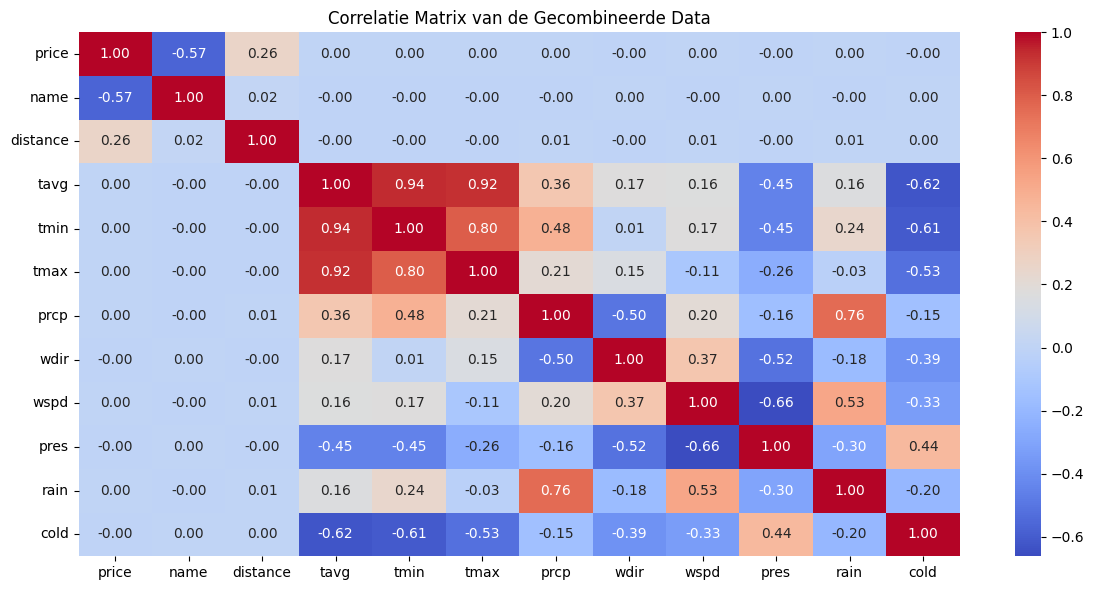

In [140]:
# correlation matrix on the weather data
corr_matrix = df_merged[["price","name", "distance", "tavg", "tmin", "tmax", "prcp", "wdir", "wspd","pres", "rain", "cold"]].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlatie Matrix van de Gecombineerde Data')
plt.tight_layout()
plt.show()


Op basis van de gegeven correlatiematrix kunnen we de volgende conclusies trekken:
- Weersvariabelen hebben bijna geen correlatie met de prijs
- Sterke onderlinge correlaties tussen temperatuur-gerelateerde variabelen

### Model trainen
We gaan exact hetzelfde model gebruiken als waarmee het oorspronkelijke model getraind is. Dit is voor regen.

In [85]:
X = df_merged[["name", "distance", "rain"]]
y = df_merged["price"]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
best_params = {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

In [88]:
# Train the model with the best parameters
best_rf = RandomForestRegressor(**best_params, oob_score=True)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=200,
                      oob_score=True)

In [89]:
y_pred = best_rf.predict(X_test)

In [93]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"OOB Score: {best_rf.oob_score_}")

Mean Squared Error: 1.9657868518365713
R^2 Score: 0.9702996810471638
OOB Score: 0.9694549693225307


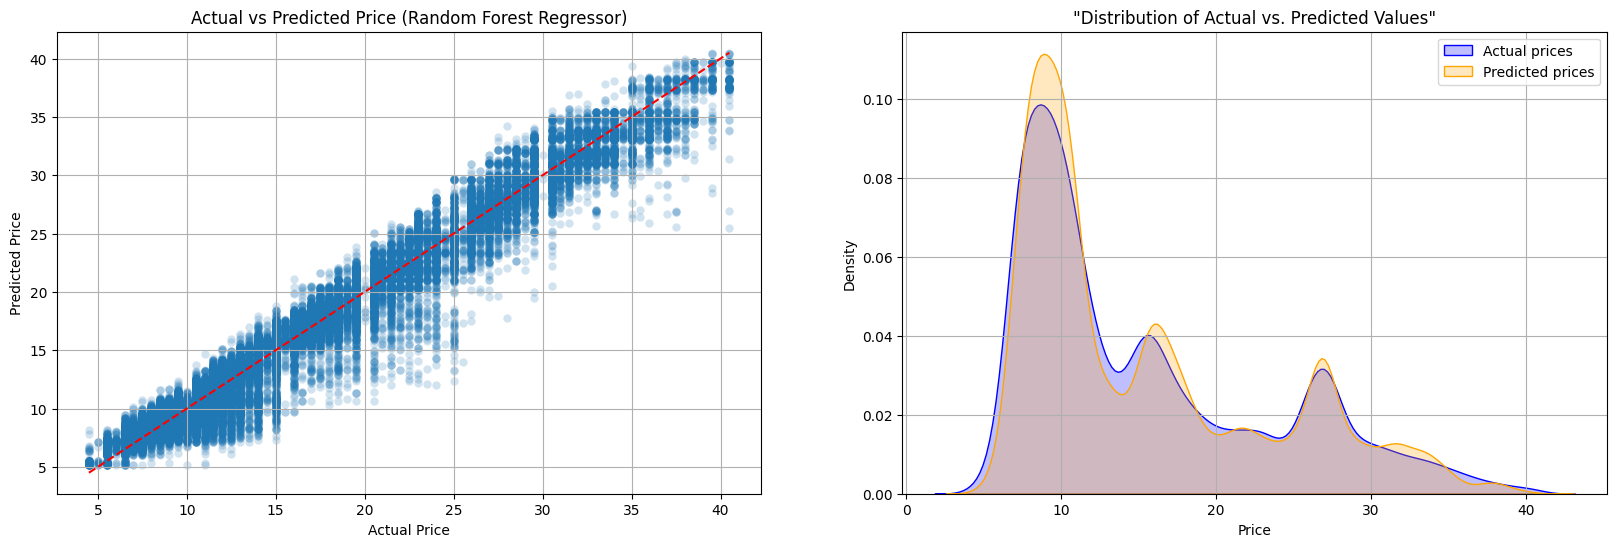

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(y_test, y_pred, alpha=0.2, marker='o', linewidths=0)
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
ax[0].grid(True)
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')
ax[0].set_title('Actual vs Predicted Price (Random Forest Regressor)')
sns.kdeplot(y_test, label='Actual prices', fill=True, color='blue')
sns.kdeplot(y_pred, label='Predicted prices' , fill=True, color='orange')
ax[1].set_xlabel('Price')
ax[1].grid(True)
ax[1].set_ylabel('Density')
ax[1].set_title('"Distribution of Actual vs. Predicted Values"')
ax[1].legend()
plt.show()

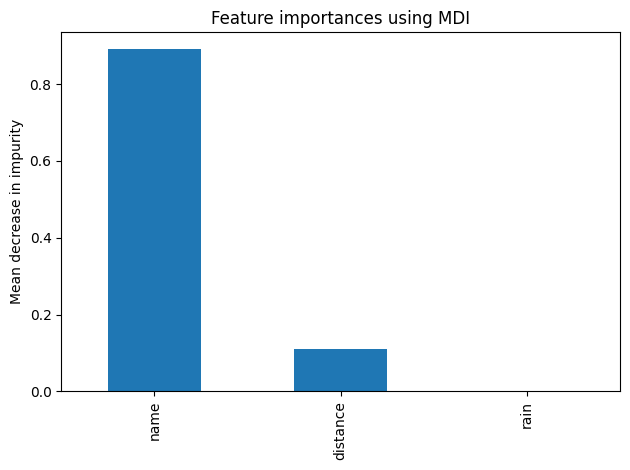

In [106]:
importances = best_rf.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [107]:
forest_importances

name        0.890508
distance    0.109248
rain        0.000244
dtype: float64

### Model trainen
We gaan exact hetzelfde model gebruiken als waarmee het oorspronkelijke model getraind is. Dit is voor de kouw.

In [96]:
X = df_merged[["name", "distance", "cold"]]  # Replace 'rain' with 'cold' for cold weather
y = df_merged["price"]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
best_params = {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

In [99]:
# Train the model with the best parameters
best_rf = RandomForestRegressor(**best_params, oob_score=True)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=200,
                      oob_score=True)

In [100]:
y_pred = best_rf.predict(X_test)

In [107]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"OOB Score: {best_rf.oob_score_}")

Mean Squared Error: 1.9611511425810435
R^2 Score: 0.9703697201988313
OOB Score: 0.9695516302197424


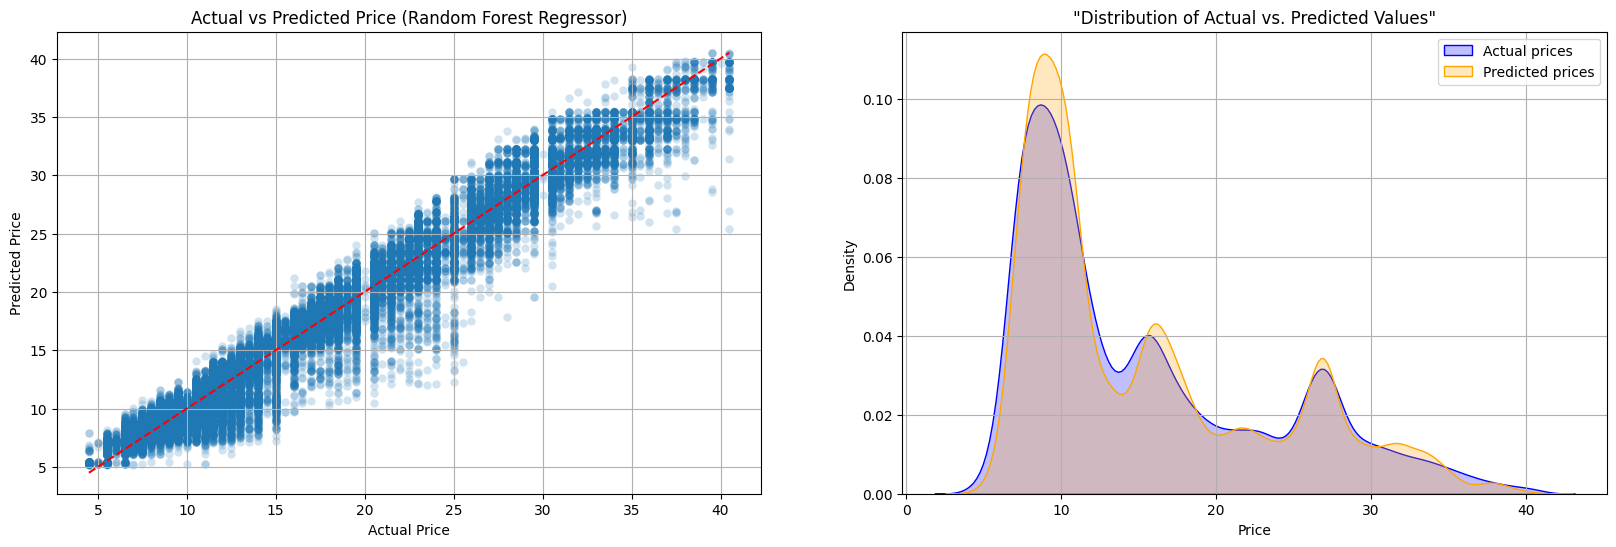

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(y_test, y_pred, alpha=0.2, marker='o', linewidths=0)
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
ax[0].grid(True)
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')
ax[0].set_title('Actual vs Predicted Price (Random Forest Regressor)')
sns.kdeplot(y_test, label='Actual prices', fill=True, color='blue')
sns.kdeplot(y_pred, label='Predicted prices' , fill=True, color='orange')
ax[1].set_xlabel('Price')
ax[1].grid(True)
ax[1].set_ylabel('Density')
ax[1].set_title('"Distribution of Actual vs. Predicted Values"')
ax[1].legend()
plt.show()

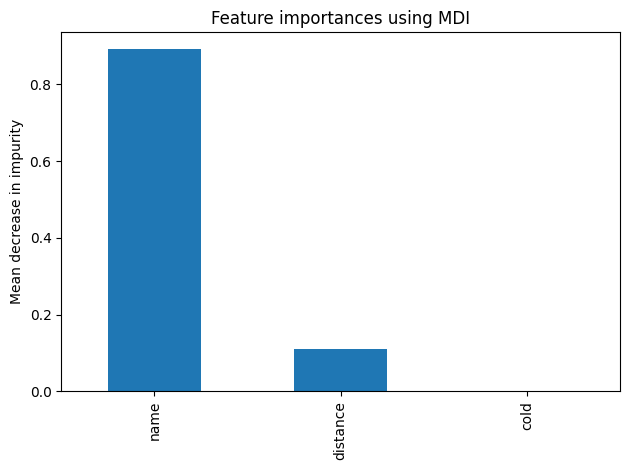

In [103]:
importances = best_rf.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [104]:
forest_importances

name        0.890591
distance    0.109263
cold        0.000146
dtype: float64

### Conclusie
Na het toevoegen van de weerdata aan het model blijkt uit de correlatiematrix dat de weersomstandigheden slechts een beperkte invloed hebben op de prijs van een taxirit. De temperatuur (tavg, tmin, tmax) en neerslag (prcp, rain) vertonen minimale correlaties met de prijs, wat suggereert dat weersvariabelen geen sterke voorspellers zijn voor de ritprijs in deze dataset. Als we nauwkeurigere weerdata hadden voor de exacte tijd en locatie (longitude en latitude), zou dit mogelijk kunnen leiden tot betere resultaten, maar aangezien er momenteel bijna geen correlatie is tussen regenval en de prijs, lijkt dit echter niet veel belovend.